In [34]:
import warnings
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_feather('./dataset/cleaned_train.feather')
print(train.shape)
train.head()

(1460, 254)


,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,BsmtQual,BsmtCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,22.544136,33.911281,1.0,3.0,7,3.036931,19.953123,4.0,4.0,3.0,...,0,0,0,1,0,0,0,0,1,0
1,26.025794,35.130490,1.0,3.0,6,4.241668,0.000000,3.0,4.0,3.0,...,0,0,0,1,0,0,0,0,1,0
2,23.260385,36.700764,2.0,3.0,7,3.036931,18.223314,4.0,4.0,3.0,...,0,0,0,1,0,0,0,0,1,0
3,21.325231,35.079833,2.0,3.0,7,3.036931,0.000000,3.0,3.0,4.0,...,0,0,0,1,1,0,0,0,0,0
4,26.915973,39.166300,2.0,3.0,8,3.036931,26.177215,4.0,4.0,3.0,...,0,0,0,1,0,0,0,0,1,0


In [3]:
print(np.exp(train.SalePrice.median()))
print(np.exp(train.SalePrice.max()))

163000.00000000012
754999.9999999999


In [4]:
test = pd.read_feather('./dataset/cleaned_test.feather')
print(test.shape)
test.head()

(1459, 239)


,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,BsmtQual,BsmtCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,30.720584,50.728195,1.0,3.0,5,6,0.000000,3.0,3.0,3.0,...,0,0,0,1,0,0,0,0,1,0
1,31.002606,54.118578,2.0,3.0,6,6,14.470534,3.0,3.0,3.0,...,0,0,0,1,0,0,0,0,1,0
2,29.006796,53.590849,2.0,3.0,5,5,0.000000,3.0,4.0,3.0,...,0,0,0,1,0,0,0,0,1,0
3,30.153513,48.336769,2.0,3.0,6,6,6.113887,3.0,3.0,3.0,...,0,0,0,1,0,0,0,0,1,0
4,19.394862,38.773079,2.0,3.0,8,5,0.000000,4.0,4.0,3.0,...,0,0,0,1,0,0,0,0,1,0


In [5]:
train[train.isin([np.nan, -np.nan, np.inf, -np.inf]).any(1)]

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,BsmtQual,BsmtCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial


In [6]:
train_target = train.pop("SalePrice")

## Model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    train,
    train_target,
    test_size=0.3,
    random_state=0
)

### Cross-Validation

In [8]:
n_folds = 5

scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_CV(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring ="neg_mean_squared_error", cv=kf))
    return np.exp(rmse)

Le RMSE permet de calculer la distance moyenne entre la target et la prédiction.

In [9]:
def prediction(model, X, y, test_X, test_y):
    m = model.fit(X, y)
    pred_train = m.predict(X)
    pred_test  = m.predict(test_X)
    print('rmse on train set', rmse_CV(m, X, y).mean())
    print('rmse on test set', rmse_CV(m, test_X, test_y).mean())
    
    return m, pred_train, pred_test

def residuals_plot(pred_train, train_y, pred_test, test_y, title):
    plt.scatter(pred_train, pred_train - train_y, c="blue",  label="Training data")
    plt.scatter(pred_test, pred_test - test_y, c="green",  label="Validation data")

    plt.title(title)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc="upper left")
    plt.hlines(y=0, xmin=pred_train.min(), xmax=pred_train.max(), color="red")
    plt.show()
    
def linear_plot(pred_train, train_y, pred_test, test_y, title):
    plt.scatter(pred_train, train_y, c="blue",  label="Training data")
    plt.scatter(pred_test, test_y, c="green",  label="Validation data")

    plt.title(title)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc="upper left")
    plt.plot([pred_train.min(), pred_train.max()], [pred_train.min(), pred_train.max()], c="red")
    plt.show()   

### Linear Regression

rmse on train set 1.1454350279405863
rmse on test set 1.2236019432940741


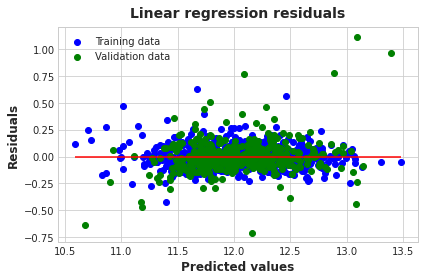

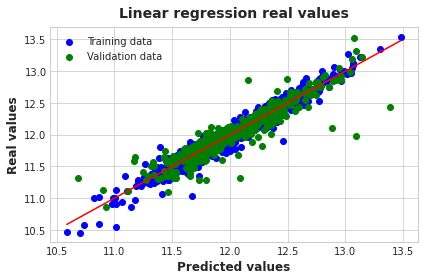

In [10]:
lr, train_lr, test_lr = prediction(LinearRegression(), X_train, y_train, X_test, y_test)
residuals_plot(train_lr, y_train, test_lr, y_test, "Linear regression residuals")
linear_plot(train_lr, y_train, test_lr, y_test, "Linear regression real values")

Les points residuelles sont dispersés de manière **random** autour de l'axe horizontal, on peut utiliser un modèle linéaire.

## Feature selection

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, SelectKBest, f_regression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### Constant features

In [12]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(train)

VarianceThreshold(threshold=0.01)

In [13]:
print(
    len([
        x for x in train.columns
        if x not in train.columns[sel.get_support()]
    ]))

train_sel = [x for x in train.columns if x not in train.columns[sel.get_support()]]
print(train_sel[:5])

train = train.loc[:, ~train.columns.isin(train_sel)]
print(train.shape)
test =  test.loc[:, ~test.columns.isin(train_sel)]
print(test.shape)

73
['KitchenAbvGr', 'has_pool', 'MSSubClass_180', 'MSSubClass_40', 'MSSubClass_45']
(1460, 180)
(1459, 182)


### Univariate features 

In [14]:
# fs = SelectKBest(score_func=f_regression, k=10)
# df_fs = fs.fit_transform(df, df_target)
# df_fs.shape

In [15]:
# fs.get_feature_names_out()

### Redundant features

In [16]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # we are interested in absolute coefficient value
                col_name = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(col_name)
    return col_corr

corr_features = correlation(train, 0.75)
print(corr_features)

train = train.loc[:, ~train.columns.isin(corr_features)]
test =  test.loc[:, ~test.columns.isin(corr_features)]

print(train.shape)
print(test.shape)

{'GarageType_None', 'Exterior2nd_CmentBd', 'Exterior2nd_MetalSd', 'MasVnrType_None', 'BldgType_2fmCon', 'HouseStyle_2Story', 'HouseStyle_1Story', 'PoolQC', 'has_bsmt', 'Exterior2nd_Wd Sdng', 'LotConfig_Inside', 'ExterCond_TA', 'Neighborhood_Somerst', 'Foundation_PConc', 'HouseStyle_1.5Fin', 'TotalSF', 'GarageCond', 'Exterior2nd_Stucco', 'TotalSqrFootage', 'BldgType_Duplex', 'Exterior2nd_Plywood', 'Foundation_Slab', 'GarageQual', 'Exterior2nd_VinylSd', 'Exterior2nd_HdBoard', 'has_fireplace', 'BldgType_TwnhsE', 'RoofStyle_Hip', 'Exterior2nd_AsbShng', 'MiscFeature_Shed', 'SaleType_WD', 'TotRmsAbvGrd', 'MiscFeature_None', 'FireplaceQu', 'has_garage', 'MSZoning_RM', 'SaleCondition_Partial', 'Electrical_SBrkr', 'HouseStyle_SLvl'}
(1460, 141)
(1459, 143)


In [17]:
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# sfs1 = SFS(RandomForestRegressor(), 
#            k_features=10, 
#            forward=True, 
#            floating=False, 
#            verbose=2,
#            scoring='r2',
#            cv=3)

# sfs1 = sfs1.fit(np.array(df_corr), df_target)

In [18]:
# sfs1.k_feature_idx_

In [19]:
# df.columns[list(sfs1.k_feature_idx_)]

### Feature Utility Scores

In [31]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores    
    
def drop_uninformative(df, mi_scores):
    return df.loc[:, df.columns.isin(mi_scores[mi_scores > 0.0].index)]

In [29]:
mi_scores = make_mi_scores(train, train_target)
mi_scores

OverallQual            0.572758
GrLivArea              0.476518
GarageCars             0.371848
YrBltAndRemod          0.353405
TotalBath              0.339321
                         ...   
Exterior2nd_BrkFace    0.000000
Exterior1st_Stucco     0.000000
Condition2_Norm        0.000000
Exterior1st_BrkFace    0.000000
GarageType_Basment     0.000000
Name: MI Scores, Length: 141, dtype: float64

In [33]:
train = drop_uninformative(train, mi_scores)
test  = drop_uninformative(test, mi_scores)

print(train.shape)
print(test.shape)

(1460, 118)
(1460, 118)


### Data preparation

In [43]:
transformer = StandardScaler().fit(train)

train_scaled = transformer.transform(train)
test_scaled = transformer.transform(test)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    train_scaled,
    train_target,
    test_size=0.3,
    random_state=0
)

Regularization is a very useful method to handle collinearity, filter out noise from data, and eventually prevent overfitting.

The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights.

Ridge and Lasso Regression are types of Regularization techniques

### Ridge Regression

In [ ]:
# ridge, train_ridge, test_ridge = prediction(
#     RidgeCV(alphas=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]), X_train, y_train, X_test, y_test
# )

# alpha = ridge.alpha_
# print('Best alpha', alpha)

# ridge, train_ridge, test_ridge = prediction(
#     RidgeCV(alphas=[alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
#                           alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
#                           alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], cv=5), 
#     X_train, y_train, X_test, y_test
# )

# alpha = ridge.alpha_
# print("Best alpha :", alpha)

# residuals_plot(train_ridge, y_train, test_ridge, y_test, "Ridge regression residuals")
# linear_plot(train_ridge, y_train, test_ridge, y_test, "Ridge regression real values")

### LASSO Regression

In [ ]:
# lasso, train_lasso, test_lasso = prediction(
#     LassoCV(alphas = [1, 0.1, 0.001, 0.0005]), X_train, y_train, X_test, y_test
# )

# residuals_plot(train_lasso, y_train, test_lasso, y_test, "Lasso regression residuals")
# linear_plot(train_lasso, y_train, test_lasso, y_test, "Lasso regression real values")

In [ ]:
# coef_lasso = pd.Series(lasso.coef_, index=train.columns)

# print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " +  str(sum(coef_lasso == 0)) + " variables")

In [ ]:
# imp_coef = pd.concat([coef_lasso.sort_values().head(10),
#                      coef_lasso.sort_values().tail(10)])

In [ ]:
# plt.figure(figsize=(10,10))
# imp_coef.plot(kind = "barh")
# plt.title("Coefficients in the Lasso Model");

Pour les coeffs négatifs, voir unbalanced categorical variables

### ElasticNet

In [45]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
l1ratio = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 1]

rmse on train set 1.1329683520822913
rmse on test set 1.1440617488301215
best alpha 0.0009
best intercept 12.022513092742814


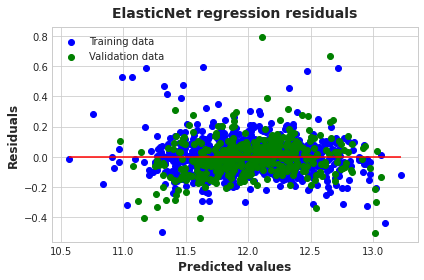

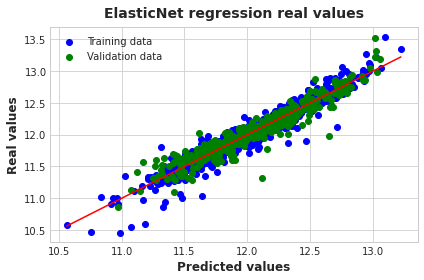

In [46]:
elasticnet, train_elasticnet, test_elasticnet = prediction(
    ElasticNetCV(max_iter=1e7, alphas=alphas, l1_ratio=l1ratio), X_train, y_train, X_test, y_test
)

print("best alpha", elasticnet.alpha_)
print("best intercept", elasticnet.intercept_)

residuals_plot(train_elasticnet, y_train, test_elasticnet, y_test, "ElasticNet regression residuals")
linear_plot(train_elasticnet, y_train, test_elasticnet, y_test, "ElasticNet regression real values")

### XGBoost

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    train,
    train_target,
    test_size=0.3,
    random_state=0
)

In [48]:
def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-0, log=True),
        n_estimators=trial.suggest_int("n_estimators", 100, 6000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return rmse_CV(xgb, X_train, y_train).mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2022-09-14 14:49:42,860] A new study created in memory with name: no-name-e4605141-2f53-4075-a6c0-d9bad7ff6953
[I 2022-09-14 14:50:57,696] Trial 0 finished with value: 1.1390343649915156 and parameters: {'max_depth': 9, 'learning_rate': 0.004353932439001169, 'n_estimators': 3842, 'min_child_weight': 7, 'colsample_bytree': 0.45946956605788536, 'subsample': 0.8338568714219894, 'reg_alpha': 0.3376003168939734, 'reg_lambda': 61.04480553245189}. Best is trial 0 with value: 1.1390343649915156.
[I 2022-09-14 14:51:57,263] Trial 1 finished with value: 1.1428516630787615 and parameters: {'max_depth': 6, 'learning_rate': 0.06339595773679878, 'n_estimators': 4108, 'min_child_weight': 1, 'colsample_bytree': 0.9799644564292735, 'subsample': 0.9433948177156468, 'reg_alpha': 0.0060894073366625934, 'reg_lambda': 0.006852160520680289}. Best is trial 0 with value: 1.1390343649915156.
[I 2022-09-14 14:52:06,273] Trial 2 finished with value: 2662.0817477510645 and parameters: {'max_depth': 2, 'learning

In [72]:
xgb = XGBRegressor(**xgb_params)

xgb.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

pred_xgb = xgb.predict(X_train)
pred_test_xgb = xgb.predict(X_test)

print('rmse on train set', rmse_CV(xgb, X_train, y_train).mean())
print('rmse on test set', rmse_CV(xgb, X_test, y_test).mean())

rmse on train set 1.1341364901430526
rmse on test set 1.1450949408163602


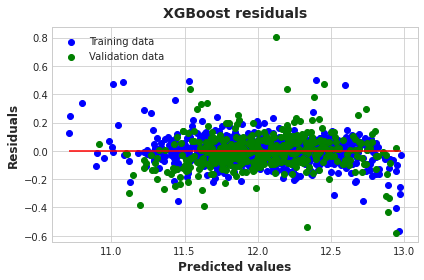

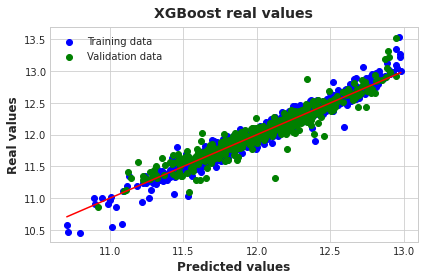

In [73]:
residuals_plot(pred_xgb, y_train, pred_test_xgb, y_test, "XGBoost residuals")
linear_plot(pred_xgb, y_train, pred_test_xgb, y_test, "XGBoost real values")

## Predict test set

In [78]:
pred = np.exp(xgb.predict(test))

results = pd.concat([test, pd.DataFrame({"SalePrice": pred})], axis=1)
results.head()

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,BsmtQual,BsmtCond,...,MoSold_8,MoSold_9,YrSold_2007,YrSold_2008,YrSold_2009,SaleType_COD,SaleType_New,SaleCondition_Abnorml,SaleCondition_Normal,SalePrice
0,22.544136,33.911281,1.0,3.0,7,3.036931,19.953123,4.0,4.0,3.0,...,0,0,0,1,0,0,0,0,1,207887.421875
1,26.025794,35.130490,1.0,3.0,6,4.241668,0.000000,3.0,4.0,3.0,...,0,0,1,0,0,0,0,0,1,178472.156250
2,23.260385,36.700764,2.0,3.0,7,3.036931,18.223314,4.0,4.0,3.0,...,0,1,0,1,0,0,0,0,1,223396.359375
3,21.325231,35.079833,2.0,3.0,7,3.036931,0.000000,3.0,3.0,4.0,...,0,0,0,0,0,0,0,1,0,170259.859375
4,26.915973,39.166300,2.0,3.0,8,3.036931,26.177215,4.0,4.0,3.0,...,0,0,0,1,0,0,0,0,1,323095.843750


In [79]:
q1 = results['SalePrice'].quantile(0.005)
q2 = results['SalePrice'].quantile(0.995)

results['SalePrice'] = results['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
results['SalePrice'] = results['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

In [81]:
print(results['SalePrice'].median())
print(results['SalePrice'].mean())
print(results['SalePrice'].max())

162494.3984375
178884.95185683324
476472.94062500005


In [ ]:
%reset -f